# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

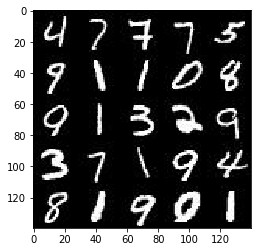

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

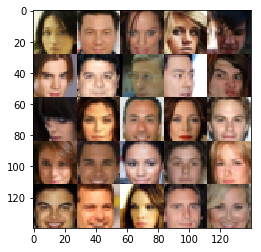

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 
                               name = 'real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), 
                             name = 'z_input')
    learning_rate = tf.placeholder(tf.float32, None, name = 'learning_rate')
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2, keep_prob=1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        d1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        relu1 = tf.maximum(alpha * d1, d1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        d2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        bn2 = tf.layers.batch_normalization(d2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        d3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        bn3 = tf.layers.batch_normalization(d3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    
    
    
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, keep_prob=1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not (is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
    
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, keep_prob=1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha, is_train=True, keep_prob=keep_prob)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha, reuse=False, keep_prob=keep_prob)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha, keep_prob=keep_prob)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    
    
    
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    
    
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    alpha = alpha
    keep_prob=1
    n_samples, width, height, channels = data_shape
    input_real, input_z, learning_rate_1 = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels, alpha=alpha, keep_prob=keep_prob)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_1, beta1)
    
    current_step = 0
    print_loss_every = 100
    show_image_every = 200
    generator_train_steps = 2
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                current_step +=1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_z = batch_z.reshape(batch_size, z_dim)
                
                _= sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_1:learning_rate})
                for i in range(generator_train_steps):    
                    _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learning_rate_1:learning_rate})
               
                if current_step % print_loss_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if current_step % show_image_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.8011... Generator Loss: 1.2050
Epoch 0/2... Discriminator Loss: 0.7630... Generator Loss: 1.5180


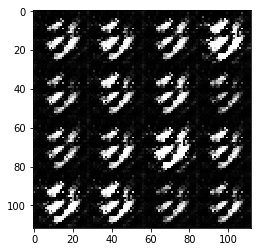

Epoch 0/2... Discriminator Loss: 0.6842... Generator Loss: 2.3980
Epoch 0/2... Discriminator Loss: 0.8285... Generator Loss: 1.6676


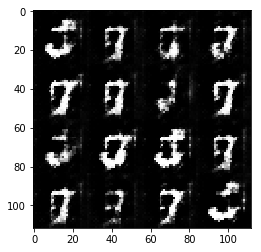

Epoch 0/2... Discriminator Loss: 1.1175... Generator Loss: 1.3541
Epoch 0/2... Discriminator Loss: 1.1622... Generator Loss: 1.0468


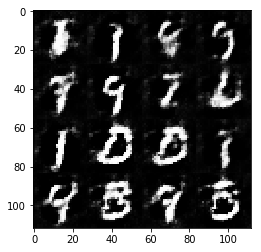

Epoch 0/2... Discriminator Loss: 1.4328... Generator Loss: 0.4935
Epoch 0/2... Discriminator Loss: 1.5325... Generator Loss: 0.5401


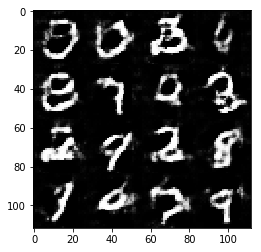

Epoch 0/2... Discriminator Loss: 1.2090... Generator Loss: 0.9623
Epoch 0/2... Discriminator Loss: 1.4114... Generator Loss: 1.0610


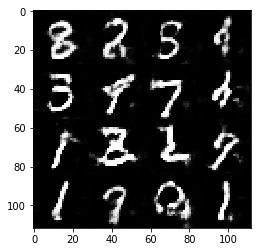

Epoch 0/2... Discriminator Loss: 1.2071... Generator Loss: 1.0900
Epoch 0/2... Discriminator Loss: 1.3476... Generator Loss: 1.4386


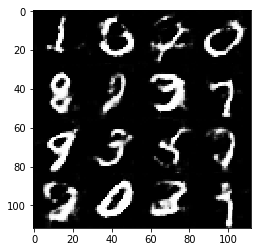

Epoch 0/2... Discriminator Loss: 1.4448... Generator Loss: 0.5737
Epoch 0/2... Discriminator Loss: 1.7489... Generator Loss: 0.3293


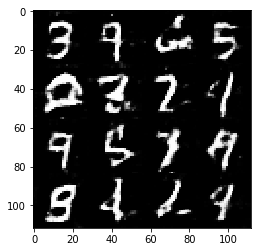

Epoch 0/2... Discriminator Loss: 1.5709... Generator Loss: 0.4173
Epoch 0/2... Discriminator Loss: 1.2813... Generator Loss: 0.6792


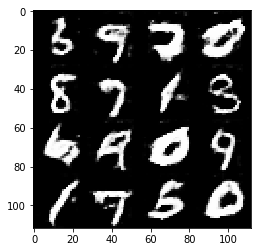

Epoch 0/2... Discriminator Loss: 1.6423... Generator Loss: 0.3832
Epoch 0/2... Discriminator Loss: 1.1793... Generator Loss: 1.0566


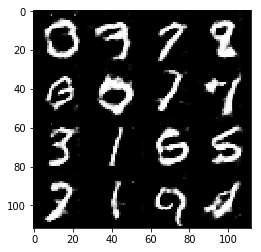

Epoch 1/2... Discriminator Loss: 1.2052... Generator Loss: 0.7187
Epoch 1/2... Discriminator Loss: 1.2829... Generator Loss: 0.8133


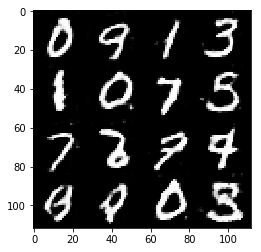

Epoch 1/2... Discriminator Loss: 1.1185... Generator Loss: 0.8196
Epoch 1/2... Discriminator Loss: 1.2523... Generator Loss: 0.6042


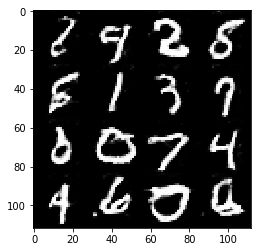

Epoch 1/2... Discriminator Loss: 1.2889... Generator Loss: 1.1420
Epoch 1/2... Discriminator Loss: 1.1953... Generator Loss: 0.6306


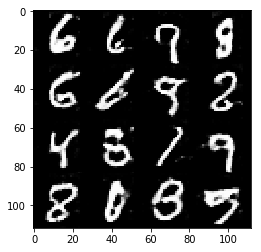

Epoch 1/2... Discriminator Loss: 1.1368... Generator Loss: 0.7002
Epoch 1/2... Discriminator Loss: 1.7129... Generator Loss: 0.9414


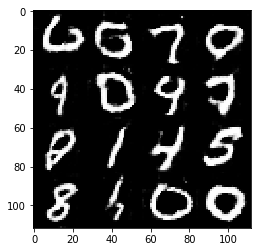

Epoch 1/2... Discriminator Loss: 1.1754... Generator Loss: 1.2173
Epoch 1/2... Discriminator Loss: 1.0395... Generator Loss: 0.9684


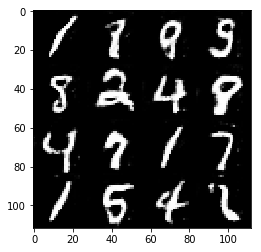

Epoch 1/2... Discriminator Loss: 1.6009... Generator Loss: 0.3962
Epoch 1/2... Discriminator Loss: 1.2144... Generator Loss: 1.5017


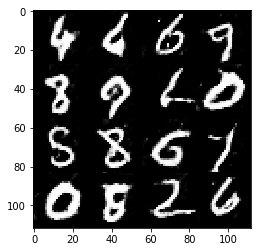

Epoch 1/2... Discriminator Loss: 1.2544... Generator Loss: 0.6432
Epoch 1/2... Discriminator Loss: 0.9621... Generator Loss: 0.9224


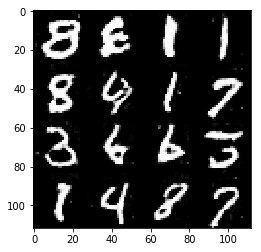

Epoch 1/2... Discriminator Loss: 1.5506... Generator Loss: 0.4125
Epoch 1/2... Discriminator Loss: 1.0139... Generator Loss: 0.9988


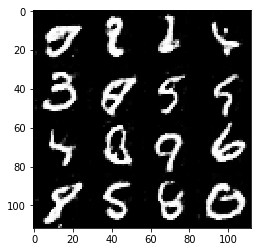

Epoch 1/2... Discriminator Loss: 1.4924... Generator Loss: 0.4658
Epoch 1/2... Discriminator Loss: 1.4527... Generator Loss: 0.4754


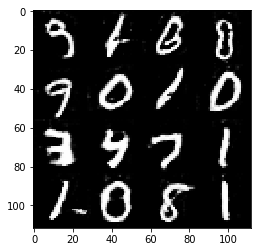

Epoch 1/2... Discriminator Loss: 1.6681... Generator Loss: 0.3828


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha = 0.08


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha)

Epoch 0/2... Discriminator Loss: 1.3220... Generator Loss: 0.8678
Epoch 0/2... Discriminator Loss: 0.9224... Generator Loss: 1.4277


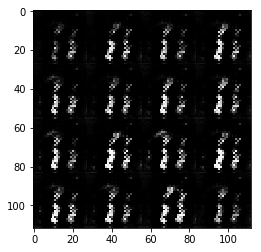

Epoch 0/2... Discriminator Loss: 1.6887... Generator Loss: 0.4106
Epoch 0/2... Discriminator Loss: 1.0688... Generator Loss: 1.1790


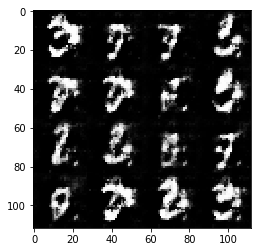

Epoch 0/2... Discriminator Loss: 1.2963... Generator Loss: 0.7257
Epoch 0/2... Discriminator Loss: 1.3197... Generator Loss: 1.0195


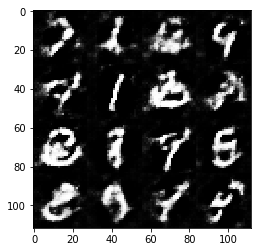

Epoch 0/2... Discriminator Loss: 1.4956... Generator Loss: 0.6001
Epoch 0/2... Discriminator Loss: 1.3262... Generator Loss: 0.6794


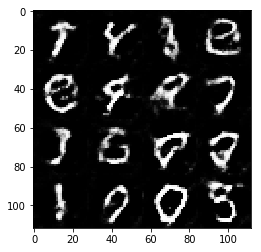

Epoch 0/2... Discriminator Loss: 1.4165... Generator Loss: 0.7220
Epoch 0/2... Discriminator Loss: 1.2265... Generator Loss: 0.9972


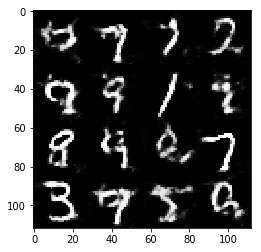

Epoch 0/2... Discriminator Loss: 1.3575... Generator Loss: 0.7959
Epoch 0/2... Discriminator Loss: 1.3519... Generator Loss: 0.7220


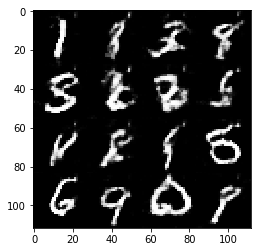

Epoch 0/2... Discriminator Loss: 1.4753... Generator Loss: 0.6231
Epoch 0/2... Discriminator Loss: 1.1643... Generator Loss: 0.7931


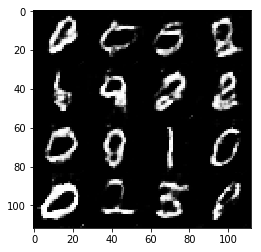

Epoch 0/2... Discriminator Loss: 1.6840... Generator Loss: 0.3358
Epoch 0/2... Discriminator Loss: 1.3011... Generator Loss: 0.7520


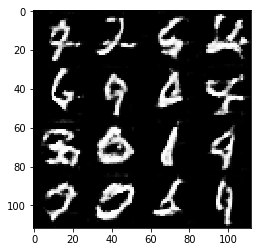

Epoch 0/2... Discriminator Loss: 1.2249... Generator Loss: 0.7614
Epoch 0/2... Discriminator Loss: 1.3326... Generator Loss: 0.6223


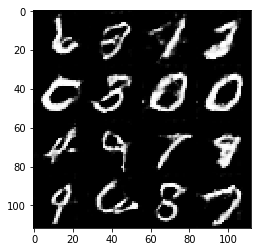

Epoch 1/2... Discriminator Loss: 1.1766... Generator Loss: 1.1304
Epoch 1/2... Discriminator Loss: 1.4101... Generator Loss: 0.9059


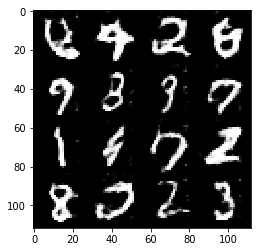

Epoch 1/2... Discriminator Loss: 1.5169... Generator Loss: 0.4150
Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 0.5919


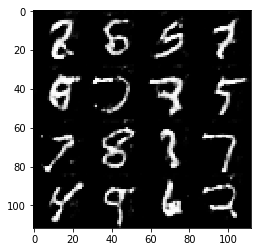

Epoch 1/2... Discriminator Loss: 1.2615... Generator Loss: 1.2039
Epoch 1/2... Discriminator Loss: 1.1280... Generator Loss: 0.8400


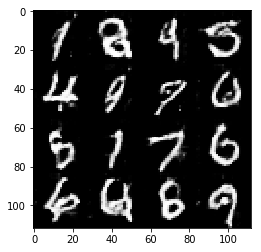

Epoch 1/2... Discriminator Loss: 1.4061... Generator Loss: 0.5119
Epoch 1/2... Discriminator Loss: 1.1828... Generator Loss: 0.7278


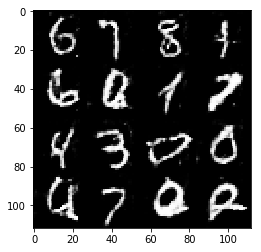

Epoch 1/2... Discriminator Loss: 1.1000... Generator Loss: 1.5144
Epoch 1/2... Discriminator Loss: 1.2112... Generator Loss: 0.6540


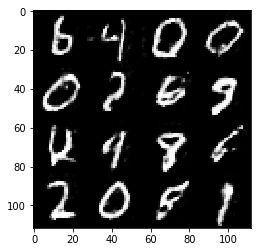

Epoch 1/2... Discriminator Loss: 1.1793... Generator Loss: 0.7557
Epoch 1/2... Discriminator Loss: 1.1634... Generator Loss: 0.7349


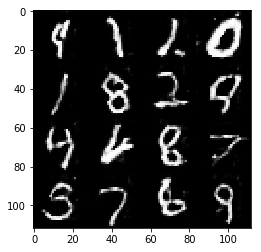

Epoch 1/2... Discriminator Loss: 1.1548... Generator Loss: 0.7954
Epoch 1/2... Discriminator Loss: 1.0735... Generator Loss: 0.7833


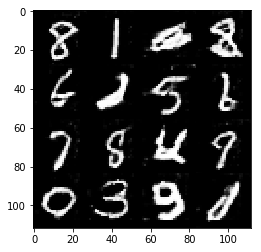

Epoch 1/2... Discriminator Loss: 1.1334... Generator Loss: 0.7038
Epoch 1/2... Discriminator Loss: 1.7843... Generator Loss: 0.2995


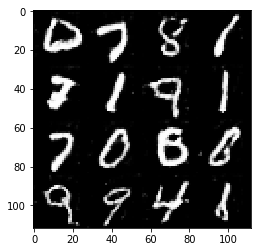

Epoch 1/2... Discriminator Loss: 1.6680... Generator Loss: 0.3586
Epoch 1/2... Discriminator Loss: 1.4857... Generator Loss: 0.4546


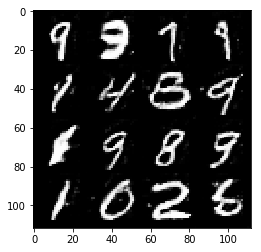

Epoch 1/2... Discriminator Loss: 1.2234... Generator Loss: 0.7128


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha = 0.12


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha)

Epoch 0/2... Discriminator Loss: 0.8772... Generator Loss: 1.9821
Epoch 0/2... Discriminator Loss: 0.8005... Generator Loss: 1.4566


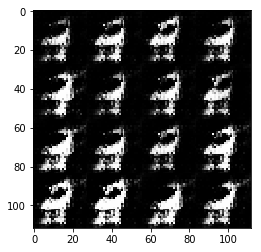

Epoch 0/2... Discriminator Loss: 0.6849... Generator Loss: 1.6916
Epoch 0/2... Discriminator Loss: 1.3808... Generator Loss: 0.9659


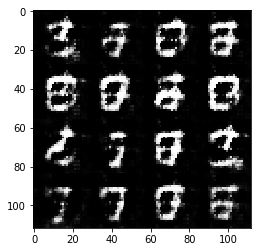

Epoch 0/2... Discriminator Loss: 1.2944... Generator Loss: 1.1200
Epoch 0/2... Discriminator Loss: 1.3045... Generator Loss: 0.7955


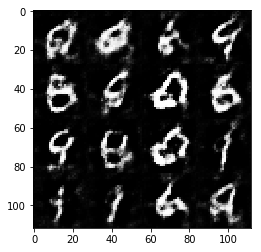

Epoch 0/2... Discriminator Loss: 1.4080... Generator Loss: 0.5366
Epoch 0/2... Discriminator Loss: 1.4308... Generator Loss: 0.4795


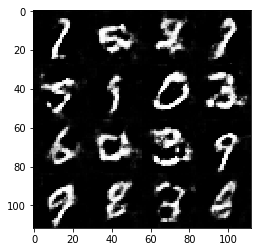

Epoch 0/2... Discriminator Loss: 1.4911... Generator Loss: 0.4993
Epoch 0/2... Discriminator Loss: 1.3461... Generator Loss: 0.5424


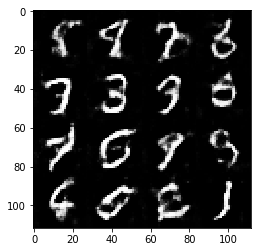

Epoch 0/2... Discriminator Loss: 1.4402... Generator Loss: 1.4041
Epoch 0/2... Discriminator Loss: 1.2453... Generator Loss: 1.0605


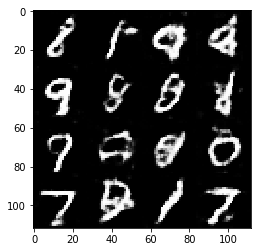

Epoch 0/2... Discriminator Loss: 1.3557... Generator Loss: 0.8516
Epoch 0/2... Discriminator Loss: 1.6273... Generator Loss: 0.3702


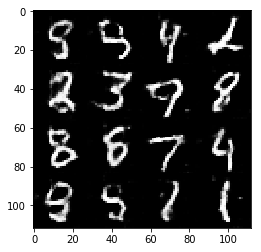

Epoch 0/2... Discriminator Loss: 1.3073... Generator Loss: 0.5998
Epoch 0/2... Discriminator Loss: 1.1908... Generator Loss: 0.7283


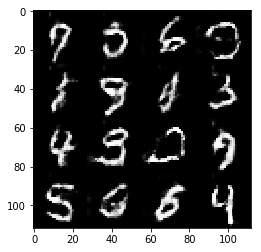

Epoch 0/2... Discriminator Loss: 1.5181... Generator Loss: 0.4493
Epoch 0/2... Discriminator Loss: 1.5700... Generator Loss: 0.4329


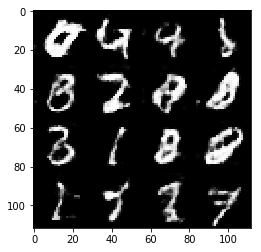

Epoch 1/2... Discriminator Loss: 1.1157... Generator Loss: 0.9366
Epoch 1/2... Discriminator Loss: 1.3610... Generator Loss: 1.5989


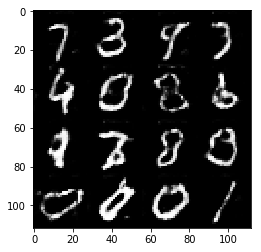

Epoch 1/2... Discriminator Loss: 1.3998... Generator Loss: 0.4993
Epoch 1/2... Discriminator Loss: 1.6841... Generator Loss: 0.3515


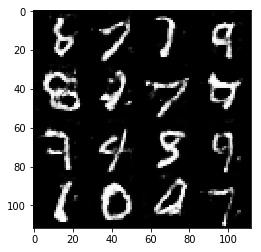

Epoch 1/2... Discriminator Loss: 1.0272... Generator Loss: 0.9486
Epoch 1/2... Discriminator Loss: 1.4742... Generator Loss: 0.7473


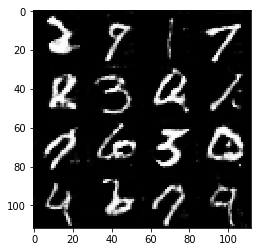

Epoch 1/2... Discriminator Loss: 1.3338... Generator Loss: 0.5559
Epoch 1/2... Discriminator Loss: 1.2355... Generator Loss: 1.5569


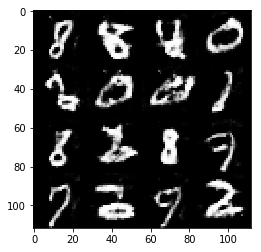

Epoch 1/2... Discriminator Loss: 1.2808... Generator Loss: 0.5899
Epoch 1/2... Discriminator Loss: 1.0362... Generator Loss: 1.1811


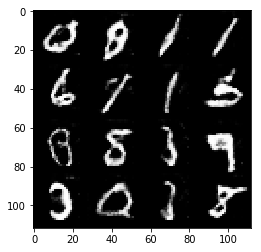

Epoch 1/2... Discriminator Loss: 1.2193... Generator Loss: 0.7195
Epoch 1/2... Discriminator Loss: 1.1231... Generator Loss: 0.7750


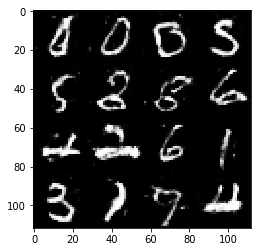

Epoch 1/2... Discriminator Loss: 2.2732... Generator Loss: 0.2230
Epoch 1/2... Discriminator Loss: 1.5081... Generator Loss: 0.4786


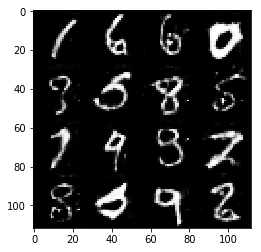

Epoch 1/2... Discriminator Loss: 1.2953... Generator Loss: 0.6769
Epoch 1/2... Discriminator Loss: 1.6180... Generator Loss: 0.3702


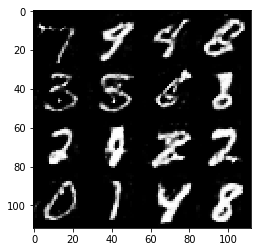

Epoch 1/2... Discriminator Loss: 1.1097... Generator Loss: 1.1771
Epoch 1/2... Discriminator Loss: 2.4732... Generator Loss: 0.1955


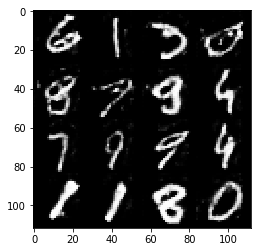

Epoch 1/2... Discriminator Loss: 0.9437... Generator Loss: 1.1102


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha = 0.15


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 1.0144... Generator Loss: 1.4609
Epoch 0/1... Discriminator Loss: 0.9863... Generator Loss: 1.1621


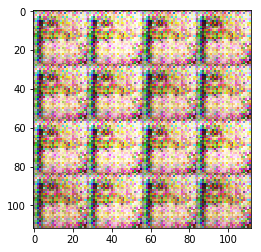

Epoch 0/1... Discriminator Loss: 1.1398... Generator Loss: 1.2571
Epoch 0/1... Discriminator Loss: 1.6390... Generator Loss: 0.7164


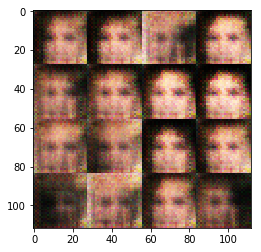

Epoch 0/1... Discriminator Loss: 1.2118... Generator Loss: 0.8963
Epoch 0/1... Discriminator Loss: 1.4136... Generator Loss: 0.8283


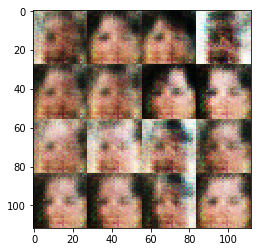

Epoch 0/1... Discriminator Loss: 1.4359... Generator Loss: 0.7115
Epoch 0/1... Discriminator Loss: 1.4336... Generator Loss: 0.7767


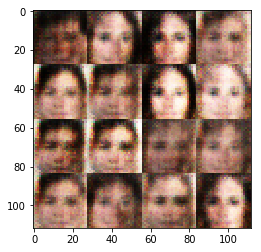

Epoch 0/1... Discriminator Loss: 1.4972... Generator Loss: 0.6993
Epoch 0/1... Discriminator Loss: 1.4810... Generator Loss: 0.7433


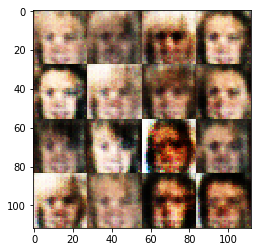

Epoch 0/1... Discriminator Loss: 1.3918... Generator Loss: 0.7901
Epoch 0/1... Discriminator Loss: 1.3933... Generator Loss: 0.7825


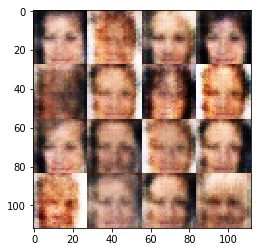

Epoch 0/1... Discriminator Loss: 1.4429... Generator Loss: 0.7310
Epoch 0/1... Discriminator Loss: 1.4022... Generator Loss: 0.7699


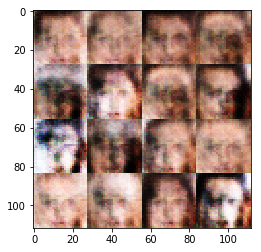

Epoch 0/1... Discriminator Loss: 1.4590... Generator Loss: 0.7702
Epoch 0/1... Discriminator Loss: 1.5308... Generator Loss: 0.7131


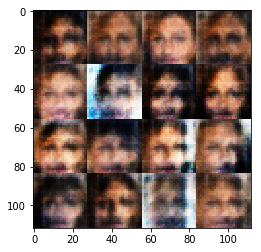

Epoch 0/1... Discriminator Loss: 1.4155... Generator Loss: 0.7958
Epoch 0/1... Discriminator Loss: 1.4281... Generator Loss: 0.7565


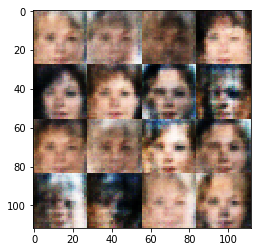

Epoch 0/1... Discriminator Loss: 1.4440... Generator Loss: 0.7662
Epoch 0/1... Discriminator Loss: 1.4878... Generator Loss: 0.8493


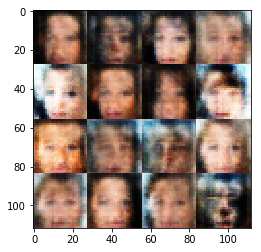

Epoch 0/1... Discriminator Loss: 1.4274... Generator Loss: 0.7487
Epoch 0/1... Discriminator Loss: 1.4240... Generator Loss: 0.7199


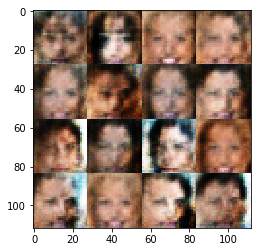

Epoch 0/1... Discriminator Loss: 1.3837... Generator Loss: 0.7872
Epoch 0/1... Discriminator Loss: 1.4173... Generator Loss: 0.7609


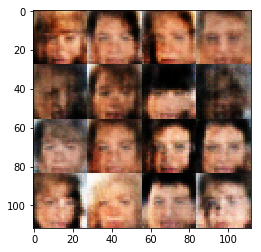

Epoch 0/1... Discriminator Loss: 1.4393... Generator Loss: 0.7674
Epoch 0/1... Discriminator Loss: 1.4238... Generator Loss: 0.7713


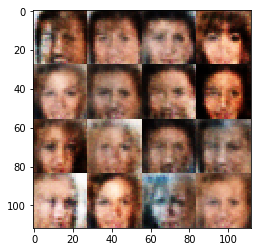

Epoch 0/1... Discriminator Loss: 1.4100... Generator Loss: 0.7540
Epoch 0/1... Discriminator Loss: 1.4438... Generator Loss: 0.7316


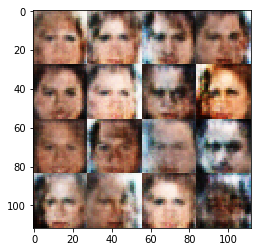

Epoch 0/1... Discriminator Loss: 1.3820... Generator Loss: 0.7869
Epoch 0/1... Discriminator Loss: 1.4109... Generator Loss: 0.7899


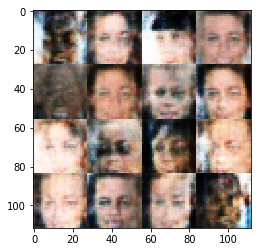

Epoch 0/1... Discriminator Loss: 1.4120... Generator Loss: 0.7563
Epoch 0/1... Discriminator Loss: 1.3995... Generator Loss: 0.7669


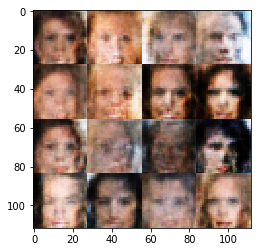

Epoch 0/1... Discriminator Loss: 1.4063... Generator Loss: 0.7755
Epoch 0/1... Discriminator Loss: 1.4259... Generator Loss: 0.7767


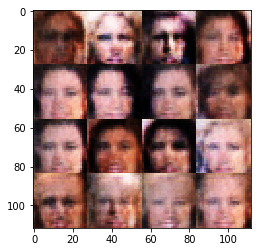

Epoch 0/1... Discriminator Loss: 1.4002... Generator Loss: 0.7894
Epoch 0/1... Discriminator Loss: 1.4276... Generator Loss: 0.7467


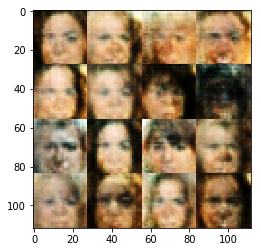

Epoch 0/1... Discriminator Loss: 1.3980... Generator Loss: 0.7605
Epoch 0/1... Discriminator Loss: 1.4250... Generator Loss: 0.7679


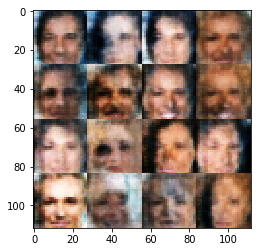

Epoch 0/1... Discriminator Loss: 1.4331... Generator Loss: 0.7915
Epoch 0/1... Discriminator Loss: 1.3975... Generator Loss: 0.8055


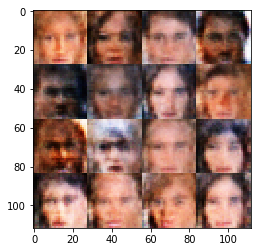

Epoch 0/1... Discriminator Loss: 1.3843... Generator Loss: 0.7975
Epoch 0/1... Discriminator Loss: 1.3999... Generator Loss: 0.7557


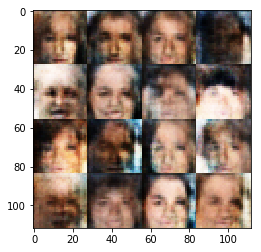

Epoch 0/1... Discriminator Loss: 1.4683... Generator Loss: 0.7694
Epoch 0/1... Discriminator Loss: 1.3799... Generator Loss: 0.7772


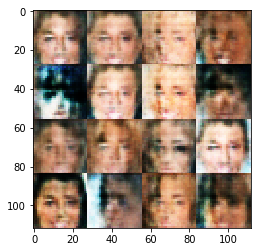

Epoch 0/1... Discriminator Loss: 1.4005... Generator Loss: 0.7908
Epoch 0/1... Discriminator Loss: 1.3782... Generator Loss: 0.8201


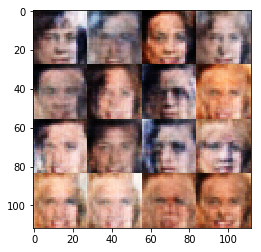

Epoch 0/1... Discriminator Loss: 1.3921... Generator Loss: 0.7736
Epoch 0/1... Discriminator Loss: 1.4195... Generator Loss: 0.7565


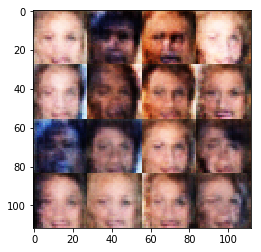

Epoch 0/1... Discriminator Loss: 1.4085... Generator Loss: 0.7273
Epoch 0/1... Discriminator Loss: 1.3775... Generator Loss: 0.7851


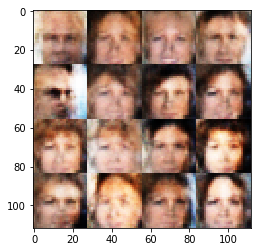

Epoch 0/1... Discriminator Loss: 1.3975... Generator Loss: 0.7794
Epoch 0/1... Discriminator Loss: 1.3912... Generator Loss: 0.7765


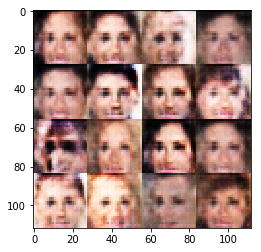

Epoch 0/1... Discriminator Loss: 1.4070... Generator Loss: 0.7941
Epoch 0/1... Discriminator Loss: 1.4091... Generator Loss: 0.7604


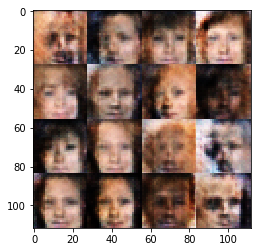

Epoch 0/1... Discriminator Loss: 1.4257... Generator Loss: 0.7773
Epoch 0/1... Discriminator Loss: 1.3980... Generator Loss: 0.7780


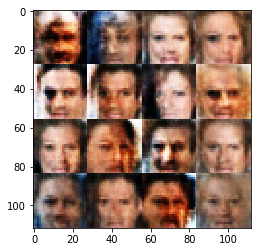

Epoch 0/1... Discriminator Loss: 1.4195... Generator Loss: 0.7765
Epoch 0/1... Discriminator Loss: 1.3832... Generator Loss: 0.7759


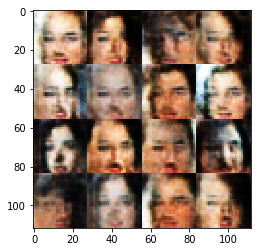

Epoch 0/1... Discriminator Loss: 1.3915... Generator Loss: 0.7642
Epoch 0/1... Discriminator Loss: 1.4047... Generator Loss: 0.7781


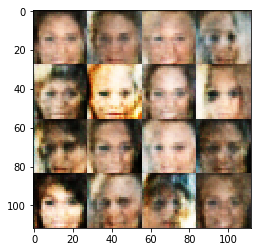

Epoch 0/1... Discriminator Loss: 1.3905... Generator Loss: 0.7986
Epoch 0/1... Discriminator Loss: 1.3695... Generator Loss: 0.7960


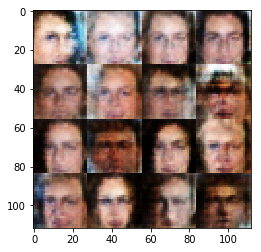

Epoch 0/1... Discriminator Loss: 1.3863... Generator Loss: 0.7572


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha = 0.08


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha)

Epoch 0/1... Discriminator Loss: 1.8963... Generator Loss: 0.8855
Epoch 0/1... Discriminator Loss: 1.1956... Generator Loss: 1.0884


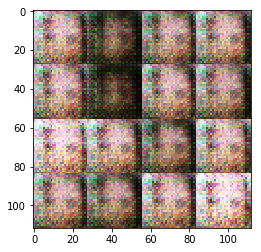

Epoch 0/1... Discriminator Loss: 1.7886... Generator Loss: 0.4993
Epoch 0/1... Discriminator Loss: 1.3758... Generator Loss: 0.8902


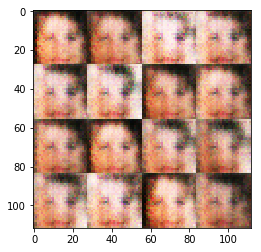

Epoch 0/1... Discriminator Loss: 1.4327... Generator Loss: 0.7677
Epoch 0/1... Discriminator Loss: 1.4283... Generator Loss: 0.7357


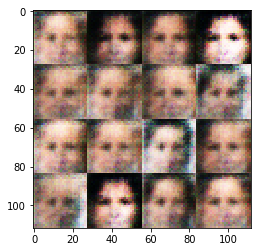

Epoch 0/1... Discriminator Loss: 1.6106... Generator Loss: 0.6268
Epoch 0/1... Discriminator Loss: 1.4537... Generator Loss: 0.7247


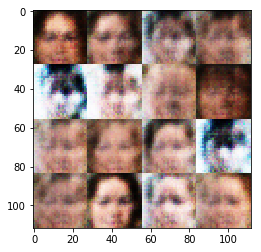

Epoch 0/1... Discriminator Loss: 1.3358... Generator Loss: 0.8232
Epoch 0/1... Discriminator Loss: 1.4310... Generator Loss: 0.7268


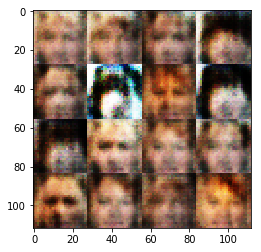

Epoch 0/1... Discriminator Loss: 1.5056... Generator Loss: 0.7045
Epoch 0/1... Discriminator Loss: 1.3972... Generator Loss: 0.8045


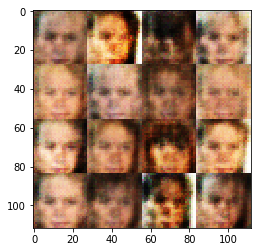

Epoch 0/1... Discriminator Loss: 1.4863... Generator Loss: 0.7022
Epoch 0/1... Discriminator Loss: 1.5186... Generator Loss: 0.7295


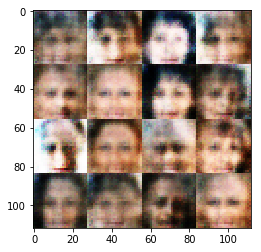

Epoch 0/1... Discriminator Loss: 1.4497... Generator Loss: 0.7982
Epoch 0/1... Discriminator Loss: 1.4284... Generator Loss: 0.7566


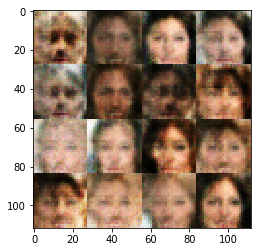

Epoch 0/1... Discriminator Loss: 1.4273... Generator Loss: 0.7513
Epoch 0/1... Discriminator Loss: 1.3996... Generator Loss: 0.7946


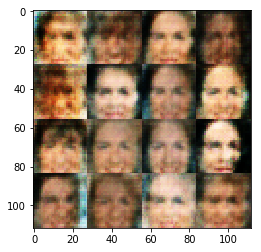

Epoch 0/1... Discriminator Loss: 1.4060... Generator Loss: 0.7917
Epoch 0/1... Discriminator Loss: 1.4810... Generator Loss: 0.7971


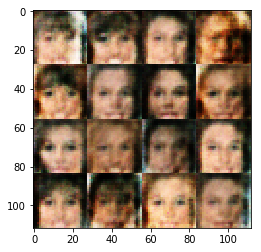

Epoch 0/1... Discriminator Loss: 1.4563... Generator Loss: 0.7370
Epoch 0/1... Discriminator Loss: 1.4199... Generator Loss: 0.7687


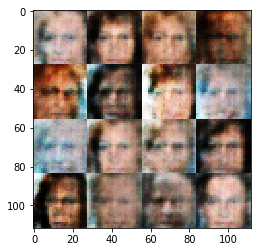

Epoch 0/1... Discriminator Loss: 1.4071... Generator Loss: 0.7655
Epoch 0/1... Discriminator Loss: 1.3705... Generator Loss: 0.8349


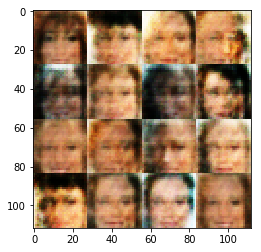

Epoch 0/1... Discriminator Loss: 1.4205... Generator Loss: 0.7731
Epoch 0/1... Discriminator Loss: 1.4448... Generator Loss: 0.7656


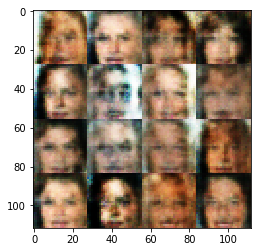

Epoch 0/1... Discriminator Loss: 1.4239... Generator Loss: 0.7570
Epoch 0/1... Discriminator Loss: 1.4165... Generator Loss: 0.7836


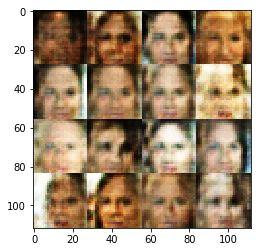

Epoch 0/1... Discriminator Loss: 1.4315... Generator Loss: 0.7627
Epoch 0/1... Discriminator Loss: 1.4523... Generator Loss: 0.7673


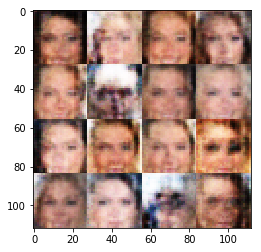

Epoch 0/1... Discriminator Loss: 1.4316... Generator Loss: 0.7556
Epoch 0/1... Discriminator Loss: 1.3923... Generator Loss: 0.7612


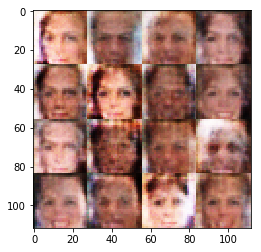

Epoch 0/1... Discriminator Loss: 1.4278... Generator Loss: 0.7688
Epoch 0/1... Discriminator Loss: 1.4173... Generator Loss: 0.7526


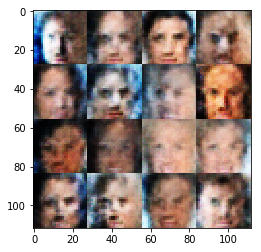

Epoch 0/1... Discriminator Loss: 1.4105... Generator Loss: 0.8205
Epoch 0/1... Discriminator Loss: 1.4104... Generator Loss: 0.8069


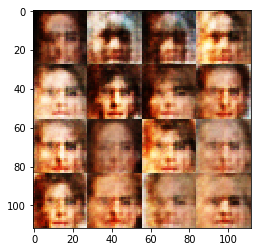

Epoch 0/1... Discriminator Loss: 1.4094... Generator Loss: 0.7403
Epoch 0/1... Discriminator Loss: 1.3848... Generator Loss: 0.7888


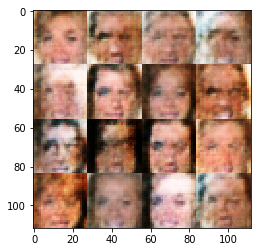

Epoch 0/1... Discriminator Loss: 1.4038... Generator Loss: 0.7926
Epoch 0/1... Discriminator Loss: 1.3939... Generator Loss: 0.7872


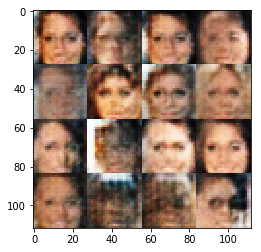

Epoch 0/1... Discriminator Loss: 1.3728... Generator Loss: 0.8016
Epoch 0/1... Discriminator Loss: 1.3872... Generator Loss: 0.7419


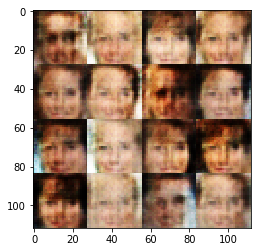

Epoch 0/1... Discriminator Loss: 1.3803... Generator Loss: 0.8390
Epoch 0/1... Discriminator Loss: 1.3956... Generator Loss: 0.7597


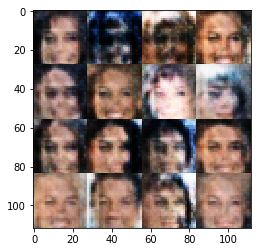

Epoch 0/1... Discriminator Loss: 1.3898... Generator Loss: 0.7814
Epoch 0/1... Discriminator Loss: 1.4024... Generator Loss: 0.7812


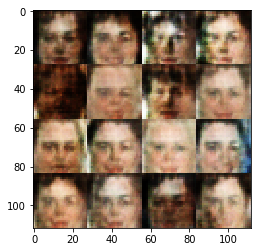

Epoch 0/1... Discriminator Loss: 1.4086... Generator Loss: 0.7444
Epoch 0/1... Discriminator Loss: 1.3976... Generator Loss: 0.7966


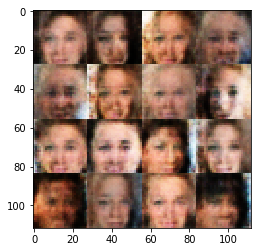

Epoch 0/1... Discriminator Loss: 1.3707... Generator Loss: 0.7603
Epoch 0/1... Discriminator Loss: 1.4056... Generator Loss: 0.7690


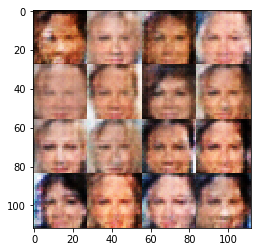

Epoch 0/1... Discriminator Loss: 1.4063... Generator Loss: 0.7532
Epoch 0/1... Discriminator Loss: 1.3854... Generator Loss: 0.8054


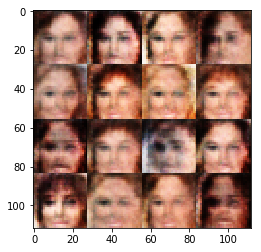

Epoch 0/1... Discriminator Loss: 1.4024... Generator Loss: 0.7743
Epoch 0/1... Discriminator Loss: 1.3664... Generator Loss: 0.8161


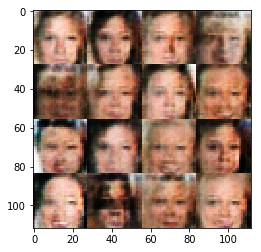

Epoch 0/1... Discriminator Loss: 1.3807... Generator Loss: 0.8001
Epoch 0/1... Discriminator Loss: 1.4271... Generator Loss: 0.7795


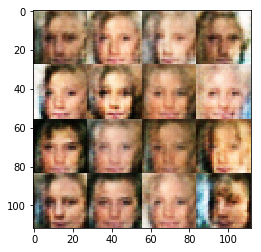

Epoch 0/1... Discriminator Loss: 1.4074... Generator Loss: 0.7818
Epoch 0/1... Discriminator Loss: 1.3980... Generator Loss: 0.7583


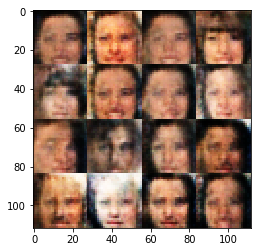

Epoch 0/1... Discriminator Loss: 1.3927... Generator Loss: 0.7897
Epoch 0/1... Discriminator Loss: 1.3960... Generator Loss: 0.7837


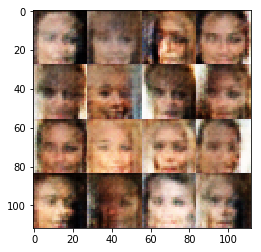

Epoch 0/1... Discriminator Loss: 1.4000... Generator Loss: 0.7922
Epoch 0/1... Discriminator Loss: 1.3993... Generator Loss: 0.7616


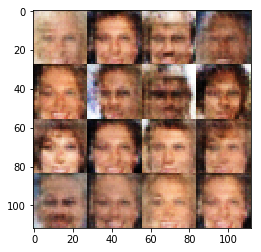

Epoch 0/1... Discriminator Loss: 1.4065... Generator Loss: 0.7378


In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha = 0.12


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha)

Epoch 0/1... Discriminator Loss: 0.8064... Generator Loss: 1.9146
Epoch 0/1... Discriminator Loss: 0.4955... Generator Loss: 2.3625


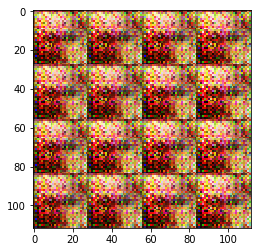

Epoch 0/1... Discriminator Loss: 1.4546... Generator Loss: 0.7211
Epoch 0/1... Discriminator Loss: 1.2790... Generator Loss: 0.9439


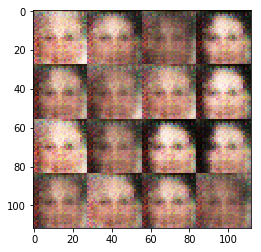

Epoch 0/1... Discriminator Loss: 1.6387... Generator Loss: 0.5880
Epoch 0/1... Discriminator Loss: 1.5239... Generator Loss: 0.6890


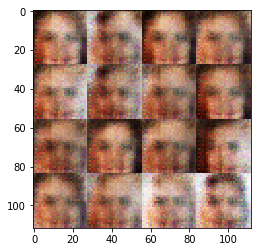

Epoch 0/1... Discriminator Loss: 1.3950... Generator Loss: 0.7376
Epoch 0/1... Discriminator Loss: 1.5198... Generator Loss: 0.7504


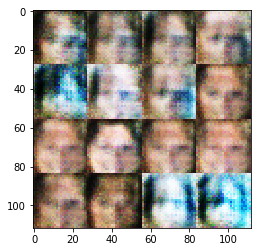

Epoch 0/1... Discriminator Loss: 1.5169... Generator Loss: 0.6917
Epoch 0/1... Discriminator Loss: 1.3968... Generator Loss: 0.7641


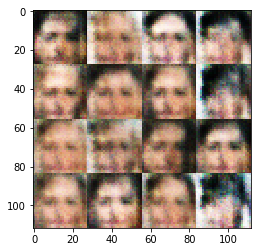

Epoch 0/1... Discriminator Loss: 1.4143... Generator Loss: 0.7332
Epoch 0/1... Discriminator Loss: 1.3566... Generator Loss: 0.8062


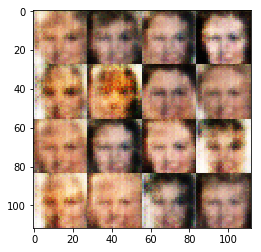

Epoch 0/1... Discriminator Loss: 1.4340... Generator Loss: 0.7054
Epoch 0/1... Discriminator Loss: 1.5473... Generator Loss: 0.6300


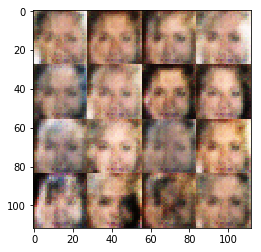

Epoch 0/1... Discriminator Loss: 1.4947... Generator Loss: 0.7071
Epoch 0/1... Discriminator Loss: 1.4431... Generator Loss: 0.7908


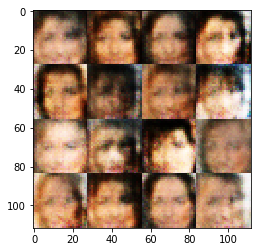

Epoch 0/1... Discriminator Loss: 1.4502... Generator Loss: 0.7344
Epoch 0/1... Discriminator Loss: 1.4327... Generator Loss: 0.7218


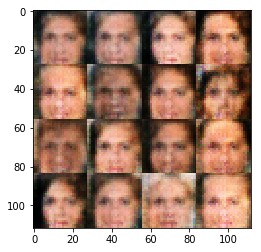

Epoch 0/1... Discriminator Loss: 1.3998... Generator Loss: 0.7820
Epoch 0/1... Discriminator Loss: 1.4939... Generator Loss: 0.7671


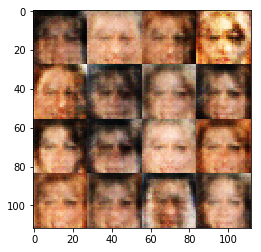

Epoch 0/1... Discriminator Loss: 1.4028... Generator Loss: 0.7706
Epoch 0/1... Discriminator Loss: 1.4338... Generator Loss: 0.7618


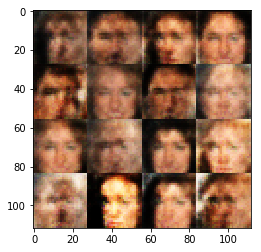

Epoch 0/1... Discriminator Loss: 1.4110... Generator Loss: 0.8214
Epoch 0/1... Discriminator Loss: 1.4652... Generator Loss: 0.7202


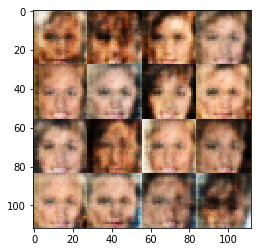

Epoch 0/1... Discriminator Loss: 1.4009... Generator Loss: 0.8017
Epoch 0/1... Discriminator Loss: 1.4308... Generator Loss: 0.7949


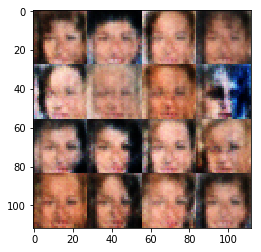

Epoch 0/1... Discriminator Loss: 1.4093... Generator Loss: 0.7530
Epoch 0/1... Discriminator Loss: 1.3783... Generator Loss: 0.7595


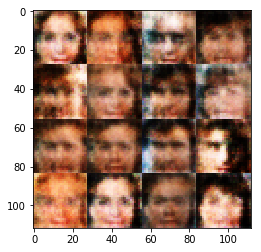

Epoch 0/1... Discriminator Loss: 1.4259... Generator Loss: 0.7720
Epoch 0/1... Discriminator Loss: 1.4195... Generator Loss: 0.8120


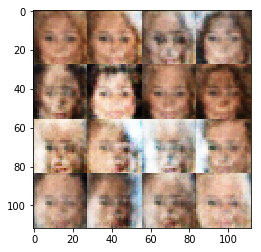

Epoch 0/1... Discriminator Loss: 1.4082... Generator Loss: 0.7776
Epoch 0/1... Discriminator Loss: 1.3895... Generator Loss: 0.8198


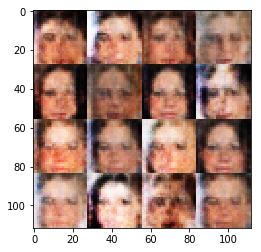

Epoch 0/1... Discriminator Loss: 1.4382... Generator Loss: 0.7848
Epoch 0/1... Discriminator Loss: 1.4356... Generator Loss: 0.7331


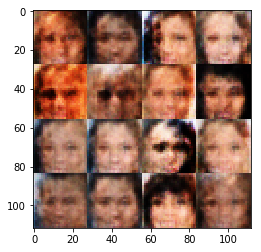

Epoch 0/1... Discriminator Loss: 1.4257... Generator Loss: 0.8086
Epoch 0/1... Discriminator Loss: 1.4159... Generator Loss: 0.7455


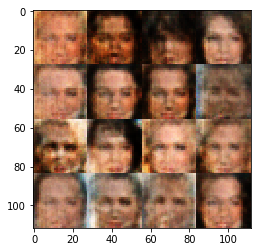

Epoch 0/1... Discriminator Loss: 1.4254... Generator Loss: 0.7450
Epoch 0/1... Discriminator Loss: 1.3875... Generator Loss: 0.7527


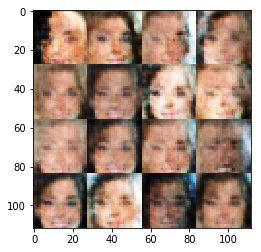

Epoch 0/1... Discriminator Loss: 1.4063... Generator Loss: 0.8097
Epoch 0/1... Discriminator Loss: 1.4002... Generator Loss: 0.7899


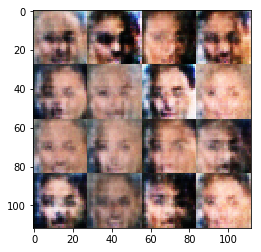

Epoch 0/1... Discriminator Loss: 1.3927... Generator Loss: 0.8179
Epoch 0/1... Discriminator Loss: 1.3939... Generator Loss: 0.7402


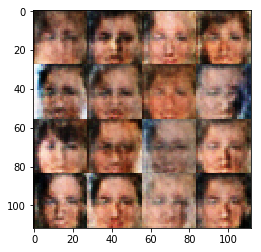

Epoch 0/1... Discriminator Loss: 1.4316... Generator Loss: 0.7784
Epoch 0/1... Discriminator Loss: 1.4000... Generator Loss: 0.7764


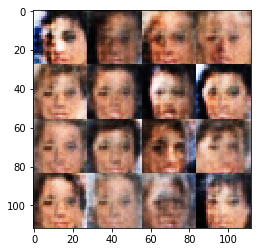

Epoch 0/1... Discriminator Loss: 1.4225... Generator Loss: 0.7691
Epoch 0/1... Discriminator Loss: 1.4012... Generator Loss: 0.7953


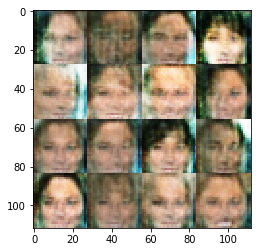

Epoch 0/1... Discriminator Loss: 1.3869... Generator Loss: 0.7600
Epoch 0/1... Discriminator Loss: 1.3679... Generator Loss: 0.8460


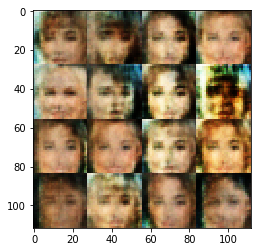

Epoch 0/1... Discriminator Loss: 1.3920... Generator Loss: 0.8029
Epoch 0/1... Discriminator Loss: 1.4164... Generator Loss: 0.8130


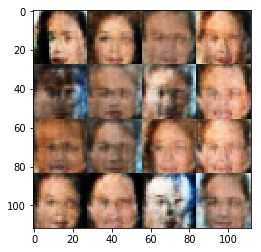

Epoch 0/1... Discriminator Loss: 1.3963... Generator Loss: 0.7468
Epoch 0/1... Discriminator Loss: 1.4370... Generator Loss: 0.7557


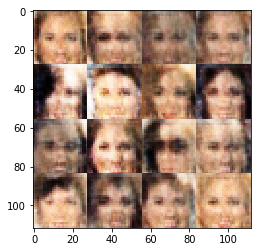

Epoch 0/1... Discriminator Loss: 1.4536... Generator Loss: 0.7785
Epoch 0/1... Discriminator Loss: 1.3965... Generator Loss: 0.7355


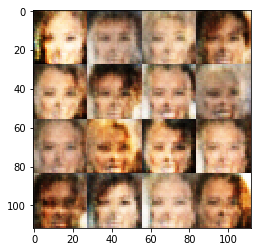

Epoch 0/1... Discriminator Loss: 1.4081... Generator Loss: 0.7666
Epoch 0/1... Discriminator Loss: 1.3730... Generator Loss: 0.7990


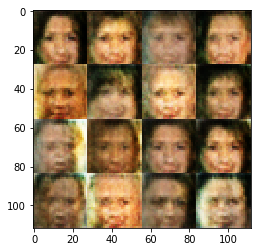

Epoch 0/1... Discriminator Loss: 1.4969... Generator Loss: 0.6668
Epoch 0/1... Discriminator Loss: 1.3890... Generator Loss: 0.7608


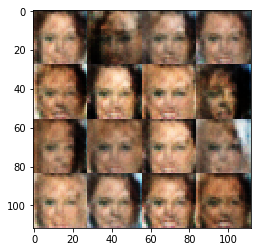

Epoch 0/1... Discriminator Loss: 1.4049... Generator Loss: 0.8101
Epoch 0/1... Discriminator Loss: 1.3815... Generator Loss: 0.8078


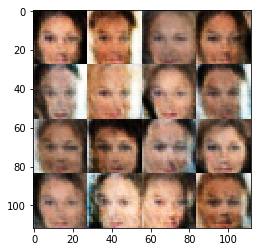

Epoch 0/1... Discriminator Loss: 1.3821... Generator Loss: 0.7558
Epoch 0/1... Discriminator Loss: 1.3818... Generator Loss: 0.8159


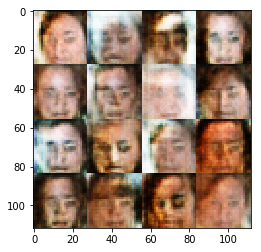

Epoch 0/1... Discriminator Loss: 1.3914... Generator Loss: 0.8061


In [17]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha = 0.15


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.